<a href="https://colab.research.google.com/github/Colley-K/capstone_projects/blob/master/1x_name_filter_8a_nu_data_cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1x Name Filter Notebook
* This notebook is not the full cleaning report, but rather a variation of the full report
* Click [here](https://colab.research.google.com/drive/195wcooDtT2XhfpRXREWmLovm8XZPNymy#scrollTo=ASb6NL6aI1xL) for the full cleaning report

**Purpose**
* The purpose of this notebook is to try out a less aggressive cleaning variation where names that occur 1 time are filtered out
>* In contrast to the original notebook, I filtered out names that occured less than ten times to catch spelling errors
* This notebook will be inherently noisier, but will be great to test out on the suprise library

**Differences from Original Cleaning**
* The 1 star ratings increased which makes logical sense that when I filtered out any routes entered less than ten times, I also filtered out the undesirable routes that recieved a few low ratings
* The shape of this data frame comes out to be : 
>* 1,733,355 entries
>* 182,132 groups of names
* The original data frame cleaning is:
>* 1,196,988 entries
>* 39,435 groups of names



#The Initial Set Up:

In [1]:
#Colab stuffs:

#get a fast operator system
!nvidia-smi

#mount google drive
from google.colab import drive
drive.mount('/content/drive')#click on the link it provides and copy and paste that code into the authorization area
!ls "/content/drive/My Drive" #shows whats in your drive once its mounted

#access the OS system to work with current directories:
import os 
os.getcwd() 

Sat May 25 19:47:44 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8    15W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

'/content'

In [2]:
#Installs
!pip install jellyfish
!pip install fuzzy
!pip install phonetics
!pip install country_converter --upgrade

#imports
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import jellyfish
import phonetics
import fuzzy
import hashlib
import base64
import country_converter as coco


#reconfigure default settings
sns.set_palette(sns.color_palette("hls", 8))
matplotlib.rc('figure', figsize = (20, 8))
matplotlib.rc('font', size = 14)
matplotlib.rc('axes.spines', top = False, right = False)
matplotlib.rc('axes', grid = False)
matplotlib.rc('axes', facecolor = 'white')

Requirement already up-to-date: country_converter in /usr/local/lib/python3.6/dist-packages (0.6.6)


#Import CSV Files
**Note:** these files were previously uploaded from the kaggle api as a sqlite database and I used the following notebook to upload and convert them to csv.files

[kaggle.api](https://colab.research.google.com/drive/1S4io5Nvz0lcnri_Lz9Mpa_TwLNeoSzGb)

In [0]:
#Turn the CSV files into data frames

ascent = pd.read_csv('drive/My Drive/Capstone/ascent.csv', low_memory=False) 

grade = pd.read_csv('drive/My Drive/Capstone/data/grade.csv', low_memory=False) #for filtering later



#Dropping Columns

In [0]:
#Dropping Columns
cols = ["user_id", "name","rating", "country", "climb_type", "grade_id"]
filter_cols = ["id", "usa_routes", "usa_boulders"]

ascent = ascent[cols]
grade = grade[filter_cols]


#Dropping the Unrated Routes

In [0]:
#Halving the data frame based on the "rating" column
ascent = ascent[ascent.rating > 0] #taking out any climb logs that were never given a star rating

#Removing the four star entries because you can only rate a climb 1-3 stars
ascent = ascent[ascent.rating < 4] #taking out any climb logs that were never given a star rating


#Removing Null Values & Converting Data Types

*I will only be removing null values in features with 5  or less null values. The "name" column (with more than 5 nulls) will be handled differently*

**Why delete nulls now?** the ratings and grade_id columns are float64 data types, but they should be int64 (example: 1.0, 2.0, 3.0). The only reason they are floats is because they have null values in their columns. 

**Action:**
* delete nulls
* convert to int64



In [0]:
#getting rid of the NaN values in the columns with less than 5 nulls
ascent= ascent.dropna(axis=0, subset=['grade_id', 'rating']) 

In [7]:
#changing data types:

cols2 = ['grade_id', 'rating'] #create a list of all the columns you want to convert to a int64
ascent[cols2] = ascent[cols2].astype('int64') #adjust the columns to int64

#double check it worked
ascent.dtypes

user_id        int64
name          object
rating         int64
country       object
climb_type     int64
grade_id       int64
dtype: object

#Detailed Feature Analysis

##*Ascent Table*

###Ratings
* 1-3 stars of how much the route was enjoyed
* 0 means not rated. Does NOT MEAN given 0 stars
>* 1993725 or 48% are 0's
>* two NaN values
* This is a vital component to our recommendation system, thus we dropped all "0" entries & NaN values so every climb has a rating corresponding to it now.
>* this decreased our data frame by 48%, but we still have aorund 2 million entries to work with which is plenty with the recommendation system

In [8]:
#seeing the distribution of ratings
ascent.rating.describe()

count    2.118144e+06
mean     2.280308e+00
std      7.365190e-01
min      1.000000e+00
25%      2.000000e+00
50%      2.000000e+00
75%      3.000000e+00
max      3.000000e+00
Name: rating, dtype: float64

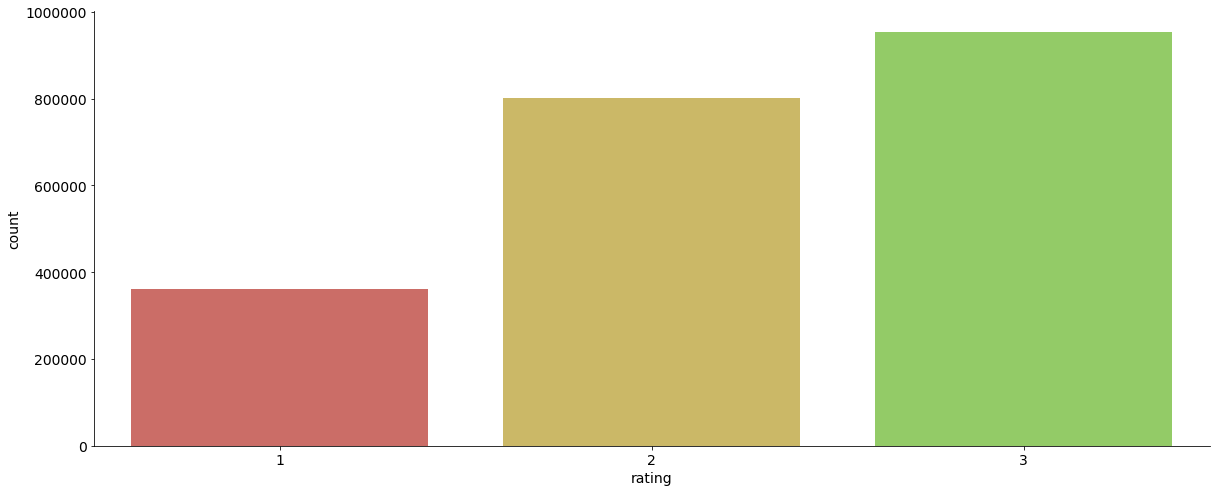

In [9]:
#graphing the distribution of values
sns.countplot(x ="rating", data= ascent)

###Name Column

* This column represents the name of the rock climb entered manually by the individual user
* This is a very important feature of the data set, as it will be the output of my recommendation system
>

**Normalizing:**

* Make the column all lower case
* Exchange the "&" sign for "and"
* **Remove**: 
>* spaces before, after, or inbetween the names
>* special characters (, . - ! ')
>>* I will not include "?" because this represents invalid names
>* take away all accent marks in foreign language names
* filter all these columns using a regex expression that only accepts letters & numbers, and turn anything that doesn't match this expression into NaN values. 
>>* after researching, I will leave numerics because there are some climbs that have all numerics as their name
* catch any phrases such as "I dont know" and turn them into NaN values
* filter out any names that are less than three characters long to catch any fake names like "x", "8", or "na"     




In [0]:
#Cleaning up objects

##need to make this more efficient- it is very slow!

ascent[["name"]] = ascent[["name"]].apply(lambda x: x.str.lower().str.replace(" ", ""))#change all to lower case and striping away blank spaces before, after, or inbetween names
ascent[["name"]] = ascent[["name"]].apply(lambda x: x.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8'))#taking away accent marks from foreign names
ascent = ascent.replace(to_replace = "[!\-'.,]", value = '', regex = True) #replacing all special characters with blanks
ascent = ascent.replace(to_replace = "[&]", value = "and", regex = True) #replacing all & characters with "and"


**Removing NaN values:** 
>* account for roughly 9% of the total data frame
>* there would not be any way to accurately guess or imputate a name for these values 
>* this will be the output of my recommendation system, thus, is a critical component of my project, and would not be wise to incorrectly guess how to fill in these values
>* since it accounts for less than 10%, I will be dropping all the NaN values
>



In [0]:
#converting non-uniform strings into NaNs

#convert the strings that dont fit the regex expression [only letters] to NaN values
ascent = ascent.replace("[^a-zA-Z0-9]", value = np.nan, regex = True) #converting anything but letters & numbers to null values

#add values such as "unknown" to the NaN group
ascent= ascent.replace(['','noname','nn','dontknow', 'idontknow', 'dontknowname', 'dunno', 'idunno', 'unknown', 'unnamed', 'noname', 'senzanome'],np.NaN, regex = True)

In [0]:
#droping the NaN's from the name column:
ascent= ascent.dropna(axis=0, subset=['name'])

#double check
assert ascent.name.notnull().all()

In [0]:
#filter out any names that are less than 3 characters:
ascent = ascent[ascent['name'].str.len() > 3]

In [14]:
#check to see df size
ascent.shape

(1962084, 6)

###Spelling Problem:
 >* There are multiple names that are spelled slightly different (example: "red rocks", "red rock canyon", "redrock canyons", "red rocks cayons"), and this will create noise in my dataset. 
>* **Potential Solutions**

   >> 1. **Phonetic Encoding**
   
   >>>* First try the jellyfish soundex algorithm to convert a string to a normalized phonetic encoding
   >>>* Next, try Double Metaphone which the author claims that in general it improves accuracy for all words to approximately 89% 
   
   >>>* This strategy would correct misspellings and encode my name column all in one line of code!
   >>>* **Potential problem** - if it too aggresively groups names together
   >>>* spell corrector would not work here because there are foreign language values
   
   >>2. **Filter Out Low Frequency Names**
   
 >>>* Although, not the most accurate answer, if a user misspells a name and enters that route on the website, the chances of another user entering and misspelling that name in the same way become less probable the greater the number of occurances. 
 >>>* First, I will look at name groupings and see what happens to the number of name groups when filtering out x amount of name occurances.  
   >>>* Next, I will filter out any names that don't occur x amount of times (to help filter out misspellings)
   
   >>3. **Fuzzy Wuzzy Techniques**
   
 >>>* If my recommendation system results are inaccurate, I will go back and look into using some fuzzy wuzzy probability ratio techniques
 >>>* However, with time contraints, I will see if the filtering technique listed above will suffice


####1. Fuzzy Techniques: Soundex

* RESULT: Too aggresive grouping
* Drops the number of groups from 66,625 to 5,793

####1. Fuzzy Techniques: Double Metaphone: *an improved & updated phonetic encoding algorithm
* RESULT: did much better than soundex, but is it too agressive still?
* Drops the number of groups from 66,625 to 12,736
* Might be too agressive still, and could instead filter out any name that occurs less than 10 times.

   
   **Encoding:** 
 >* In order for the name column to work with the surprise collaborative algorthim, the name column must be encoded 
 >* Use base64 hashing to handle this large scale data set & numerous values

In [0]:
#Base64 Hash *turns into a byte
ascent['name_id']= ascent["name"].astype(str).str.encode('UTF-8')\
          .apply(lambda x: base64.b64encode(hashlib.sha1(x).digest())) 

####2. Filtering Out Lower Frequency Names
* As showing in the graph below, the amount of groupings half, when filtering out any names that only occur one time
* This notebook will represent a nosier data set, and so we will only filter out any names that occur 1 time, and leave any names with any occurances two or more times.
* this will leave close to 200,000 groupings which is plenty to play aorund with

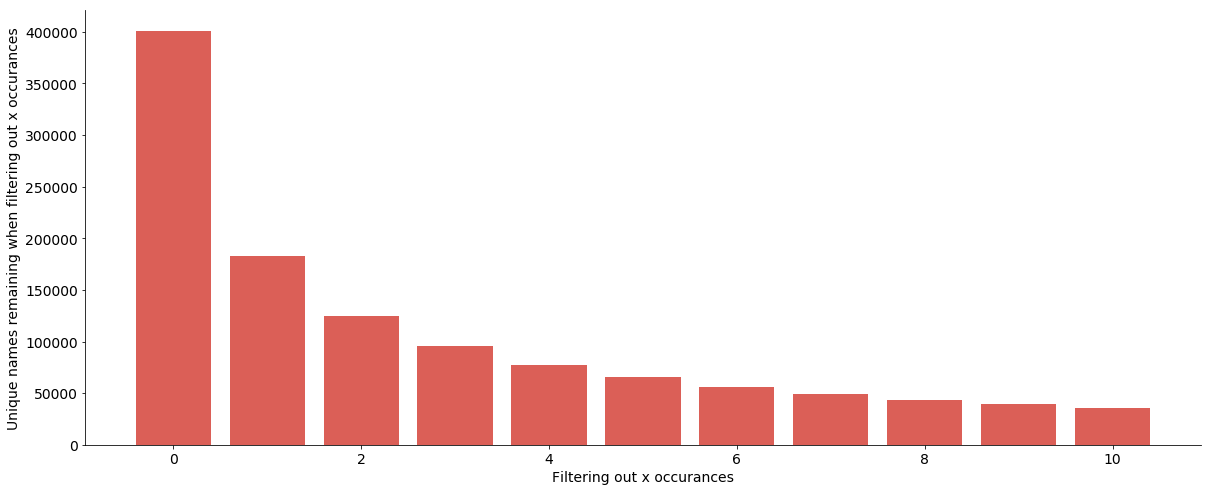

In [16]:
#graphing what happens to the number of unique values when filtering out x number of occurances
plot_counts= {0:401030, 1:182957, 2:124409, 3:95373, 4:77549, 5:65313, 6:56234, 7:49296, 8:43721, 9:39268, 10:35597}
plt.bar(*zip(*plot_counts.items()))
plt.xlabel("Filtering out x occurances")
plt.ylabel("Unique names remaining when filtering out x occurances")
plt.show()

In [17]:
#filtering out names that occur < 10 times to filter out spelling errors

ascent= ascent.groupby('name').filter(lambda x: len(x) > 1)

#count the number of name groups left in dataframe
ascent.name.nunique()

184025

In [18]:
#count number of entries left in the dataframe
ascent.shape

(1740874, 7)

###Climb Type:
* 0 = rope climbing
* 1 = bouldering
* approx. double the amount of rope climbs logged versus bouldering climbs
* *may want to think about segmenting these different climbs into different groups because typically boulderers are just wanting boulder routes and vice versa with rope climbs*

###Grade ID:
* difficulty of climb 1-86 
* this rating system makes it possible to compare ratings across different countries rating systems
* 49 (USA 11d) is the most logged climbing grade
* Changed to int 64  from a float
* need to merge with grade table to get the full description of grades
* the 0's and low numbers are valid easy rated routes


###Country 
* Country is entered via a drop down selection provided on website, however there are still a few incorrect entries

**Country Normalization** :
>1. Make column capital letters
>2. Use the country_converter to check if country values are valid, if not, I will turn them into null values
>3. Will use the mode aggregation per route name to populate null values of the country column


In [0]:
#make the country column capital letters
ascent['country'] = ascent.country.str.upper()

####Country Converter

* finds all values that are not valid three digit country codes, and converts them into NaN values
* VERY computationally expensive, thus I only ran once, and found that YUG & ROM where incorrectly entered.
* Country coverter docs:
[githug](https://github.com/konstantinstadler/country_converter/blob/master/country_converter/country_converter.py)


In [0]:
#Using Country Converter to convert non valid three digit codes into NaNs
#this code is VERY computationally expensive. Thus, I will not run this twice, but it found a few "ROM" & "YUG" values that are invalid country codes, and I will drop these rows from the table


#ascent['country']= ascent["country"].apply(lambda x: coco.convert(names= x, to='ISO3', not_found= np.NaN)) 

In [21]:
#ROM, YUG ARE NOT COUNTRIES, need to filter them out of the dataframe
ascent= ascent[(ascent.country != 'ROM') & (ascent.country != 'YUG')]
ascent.isnull().sum()

user_id           0
name              0
rating            0
country       29979
climb_type        0
grade_id          0
name_id           0
dtype: int64

####Imputing the Country's NaNs with the mode based on the name column
* Will groupby the route name column and then compute the mode of the country column to fill in the NaNs



In [22]:
ascent.isnull().sum()

user_id           0
name              0
rating            0
country       29979
climb_type        0
grade_id          0
name_id           0
dtype: int64

In [0]:
#First drop the NaNs from the country column, then groupby the name category, and compute the mode of the country
mode_1 = ascent.dropna().groupby('name')['country'].agg(pd.Series.mode).reset_index()

#Next, create a dictionary out of the mode values, grouped by the name
mapping_dict = dict(mode_1.values)

#finally fill in the country column NaN's with the mapping of the dictionary
ascent.country = ascent.country.fillna(ascent.name.map(mapping_dict))

In [24]:
ascent.isnull().sum()

user_id          0
name             0
rating           0
country       2439
climb_type       0
grade_id         0
name_id          0
dtype: int64

In [0]:
#see how many nulls are left in the table
ascent.isnull().sum()

#deleting the reamining nulls from the country column (that didn't have a mode except NaN)
ascent= ascent.dropna(axis=0, subset=['country'])

#double check
assert ascent.country.notnull().all()


##*Grade Table*

####ID:
*  numbered 1-86 
* corresponds to the ascent table & it gives each climb a number 1-86 that corresponds to different rating systems in the US and France
* this column is correctly coded as an int64 data type, no work needs to be done on this column

In [28]:
grade.head()

,id,usa_routes,usa_boulders
0,1,3/4,VB
1,2,NaN,NaN
2,3,NaN,NaN
3,4,NaN,NaN
4,5,NaN,NaN


####Routes & Boulders:
* Need to forward fill all the USA columns so they correspond to the more numerous French Columns

In [0]:
#used forward fill on the USA values
grade[["usa_routes", "usa_boulders"]]= grade[["usa_routes", "usa_boulders"]].fillna(method='ffill')

In [0]:
#double check the table 
grade.head(10)

#Exporting Data Frames to CSV 

###Step 1: 

* copy the ascent table, and delete all rows except the three rows for the recommendation system (user_id, name_id, rating)


In [0]:
#create a new data frame that will serve as the reference to the recommendation table
ref_table_1x = ascent.copy(deep=True)



###Step 2:
* merge the grade table with the reference table so all reference items are in one table

In [0]:
#left merge the reference table with grade table
ref_table_1x = ref_table_1x.merge(grade,how='left', left_on='grade_id', right_on='id')


###Step 3:
* drop unneccary columns in both data frames

In [0]:
ref_table_1x= ref_table_1x.drop(labels= ["id"], axis=1)
ascent_1x = ascent[["user_id", "name_id", "rating"]]

###Final Shape of the Data Frames:

In [36]:
#how many name groups
ascent.name_id.nunique()

182132

In [38]:
#number of entries in both tables:
ref_table_1x.shape
ascent_1x.shape

(1733355, 3)

###Step 4:
* export files to google drive

In [0]:
from google.colab import files
ref_table_1x.to_csv(r'/content/drive/My Drive/Capstone/data/ref_table_1x.csv', index = "user_id", header=True)
ascent_1x.to_csv(r'/content/drive/My Drive/Capstone/data/ascent_1x.csv', index = "user_id", header=True)
